In [1]:
%cd ~/mmyolo
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import math

/home/jiangtianbin/mmyolo


## COCO format

In [2]:
# for example
ann_file_example = {
'images': [
    {
        'file_name': 'COCO_val2014_000000001268.jpg',
        'height': 427,
        'width': 640,
        'id': 1268
    },
    # ...
],

'annotations': [
    {
        'segmentation': [[192.81,
            247.09,
            # ...
            219.03,
            249.06]],  # 如果有 mask 标签且为多边形 XY 点坐标格式，则需要保证至少包括 3 个点坐标，否则为无效多边形
        'area': 1035.749,
        'iscrowd': 0,
        
        'image_id': 1268,
        # x1, y1, w, h
        'bbox': [192.81, 224.8, 74.73, 33.43],
        'category_id': 16,
        'id': 42986
    },
    # ...
],

'categories': [
    {'id': 0, 'name': 'car'},
 ]
}

## load data

In [2]:
import json

def read_josn(path):
    with open(path, 'r') as f:
        data = json.load(f)
        return data

## LN to LT

### fov_alignment
fov alignment between event camera and RGB camera

1. Assume that the scene is infinitely far away
2. Compute the projection matrix that maps a pixel coordinate of the left event camera to the pixel coordinate in the left global shutter camera:

$$
P_{r1\_r0} = K_{r1} * R_{r1\_1} * R_{1\_0} * R^{-1}_{r0\_0} * K^{-1}_{r0}
$$

3. Compute this mapping for each pixel of the left event camera frame (make sure to normalize the homogeneous vector before retrieving the pixel coordinates)
4. Use opencv's remap function to remap the left image pixels to the left event camera pixels

opencv remap:

$$
dst[x, y] = src(map_x[x, y], map_y[x, y])
$$

inverse remap:

$$
dst\_inv[x, y] = dst(map\_x\_inv[x, y], map\_y\_inv[x, y])
$$

### calibration parameters

In [3]:
Kr1 = np.array([
    [1164.6238115833075, 0, 713.5791168212891],
    [0, 1164.6238115833075, 570.9349365234375],
    [0,0,1]
])

Kr0 = np.array([
    [569.7632987676102, 0, 335.0999870300293],
    [0, 569.7632987676102, 221.23667526245117],
    [0,0,1]
])

Kr2 = np.array([
    [1164.6238115833075, 0, 713.5791168212891],
    [0, 1164.6238115833075, 570.9349365234375],
    [0,0,1]
])

T32 = np.array([
    [0.9999880111304372, -0.003533401537847065, -0.003390083916194203, -0.04551026028184807],
    [0.003476600244706753, 0.9998558803824363, -0.016617211420558598, -0.001048727690114844],
    [0.0034483106189848347, 0.016605226232405814, 0.999856177465359, 0.013554100781902953],
    [0.0, 0.0, 0.0, 1.0]
])

T10 = np.array([
    [0.9996874046885865, 0.009652146488870916, 0.023063585478994113, -0.04410263392688484],
    [-0.009722042371104245, 0.9999484753460813, 0.0029203673010648615, 0.0005281285423087664],
    [-0.023034209322743096, -0.0031436795631953228, 0.9997297347181744, -0.01229891454144492],
    [0,0,0,1]
])

R_rect2 = np.array([
    [0.9999366804437944, 0.003969348920710642, -0.010529927454197178],
    [-0.004003571037888531, 0.9999867662646432, -0.0032308999561175607],
    [0.010516963534670165, 0.003272852689552886, 0.99993933911677]
])

R_rect3 = np.array([
    [0.9999322651093031, 0.008652073287418781, -0.0077850382919819015],
    [-0.008624936114678652, 0.9999566349120226, 0.003512658884929655],
    [0.007815092475217568, -0.0034452754974453855, 0.9999635265380186]
])

R_rect1 = np.array([
    [0.9998572179847892, -0.013025778024398856, -0.010764420587133948],
    [0.013060715513432202, 0.9999096430275752, 0.003181743349841093],
    [0.01072200326407413, -0.0033218800890692088, 0.9999369998948329]
])

R_rect0 = np.array([
    [0.9999313912417018, -0.0023139054373197965, 0.011482972222461762],
    [0.002353841678837691, 0.9999912245858043, -0.003465570766066675],
    [-0.011474852451585301, 0.0034923620961737592, 0.9999280629966356]
])



### get index mapping

In [4]:
# rgb view to event view

Mr1_r0 = np.matmul(Kr1, R_rect1)
Mr1_r0 = np.matmul(Mr1_r0, T10[:3,:3])
Mr1_r0 = np.matmul(Mr1_r0, np.linalg.inv(R_rect0))
Mr1_r0 = np.matmul(Mr1_r0, np.linalg.inv(Kr0))

map_x = np.zeros((480, 640), dtype=np.float32)
map_y = np.zeros((480, 640), dtype=np.float32)

for col in range(640):
    for row in range(480):
        Pr0 = np.array([col, row, 1]).transpose()
        Pr1 = np.matmul(Mr1_r0, Pr0)
        map_x[row, col] = Pr1[0]/Pr1[2]
        map_y[row, col] = Pr1[1]/Pr1[2]


# event view to rgb view (inverse)

map_x_inv = np.zeros((1080, 1440), dtype=np.float32)
map_y_inv = np.zeros((1080, 1440), dtype=np.float32)

Mr0_r1 = np.linalg.inv(Mr1_r0)

for col in range(1440):
    for row in range(1080):
        Pr1 = np.array([col, row, 1]).transpose()
        Pr0 = np.matmul(Mr0_r1, Pr1)
        map_x_inv[row, col] = Pr0[0]/Pr0[2]
        map_y_inv[row, col] = Pr0[1]/Pr0[2]


print(np.max(map_x_inv), np.min(map_x_inv))
print(np.max(map_y_inv), np.min(map_y_inv))
# minus value is out of right-top bounding of the image.
# the value that is more larger than width or height is out of left-bottom bounding of the image.


690.8263 -16.616405
463.6112 -65.30652


### show difference

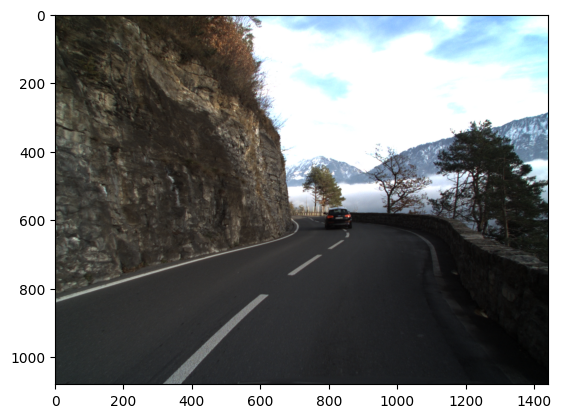

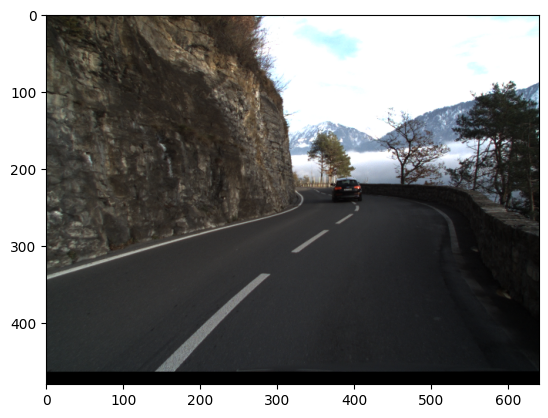

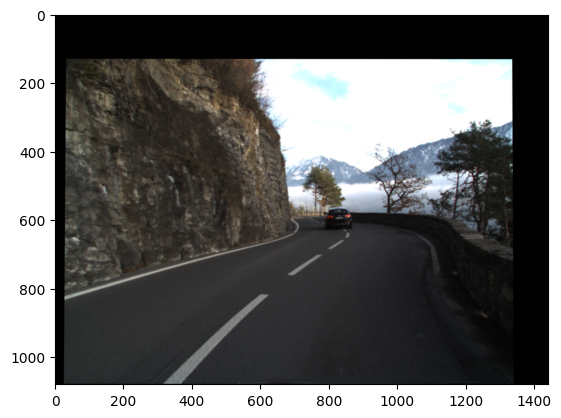

In [5]:
path = 'data/DSEC/test/images/interlaken_00_a/images/left/rectified/000223.png'

src = cv2.imread(path)
dst = cv2.remap(src, map_x, map_y, cv2.INTER_LINEAR)
dst_inv = cv2.remap(dst, map_x_inv, map_y_inv, cv2.INTER_LINEAR)

plt.figure()
plt.imshow(src[:,:,[2,1,0]].astype(np.uint8))

plt.figure()
plt.imshow(dst[:,:,[2,1,0]].astype(np.uint8))

plt.figure()
plt.imshow(dst_inv[:,:,[2,1,0]].astype(np.uint8))

### do LN to LT transform

In [7]:
assert 0, 'cuation for executing this cell again'
# here, x is col, y is row
map_row_inv = map_y_inv 
map_col_inv = map_x_inv

e = 1e-6

def check_out_border(v, bound):
    if v < 0:
        return .0
    elif v >= bound:
        return bound - e
    else:
        return v

def new_x(x, y):
    # billnear interpolation
    if x > 1440 - 1:
        x = 1440 - 1
    if y > 1080 - 1:
        y = 1080 - 1
    total = .0
    total += map_col_inv[math.floor(y), math.floor(x)] 
    total += map_col_inv[math.floor(y), math.ceil(x)]
    total += map_col_inv[math.ceil(y), math.floor(x)]
    total += map_col_inv[math.ceil(y), math.ceil(x)]
    v = total / 4
    v = check_out_border(v, 640)
    assert 0 <= v < 640, print('assert: value = ', v)
    return v

def new_y(x, y):
    # billnear interpolation
    if x > 1440 - 1:
        x = 1440 - 1
    if y > 1080 - 1:
        y = 1080 - 1
    total = .0
    total += map_row_inv[math.floor(y), math.floor(x)] 
    total += map_row_inv[math.floor(y), math.ceil(x)]
    total += map_row_inv[math.ceil(y), math.floor(x)]
    total += map_row_inv[math.ceil(y), math.ceil(x)]
    v = total / 4
    v = check_out_border(v, 480)
    assert 0 <= v < 480, print('assert: value = ', v)
    return v


def x1y1wh2xyxy(x1, y1, w, h):
    x2 = x1 + w
    y2 = y1 + h
    return x1, y1, x2, y2

def xyxy2x1y1wh(x1, y1, x2, y2):
    w = x2 - x1
    h = y2 - y1
    return x1, y1, w, h


ann_path = Path('DSEC-Soft/soft_ann/soft_ann_train_LN.json')
out_path = Path('DSEC-Soft/soft_ann/soft_ann_train_LT.json')

# ann_path = Path('DSEC-Soft/soft_ann/soft_ann_test_LN.json')
# out_path = Path('DSEC-Soft/soft_ann/soft_ann_test_LT.json')
ann_data = read_josn(ann_path)

images = ann_data['images']

annotations = ann_data['annotations']

for img in images:
    img['height'] = 480
    img['width'] = 640
    img['file_name'] = img['file_name'].replace('left/rectified/', 'transformed_images/')
    
for ann in annotations:
    x1, y1, x2, y2 = x1y1wh2xyxy(*ann['bbox'])
    new_bbox = [new_x(x1, y1), new_y(x1, y1), new_x(x2, y2), new_y(x2, y2)]
    x1, y1, w, h = xyxy2x1y1wh(*new_bbox)
    ann['bbox'] = [x1, y1, w, h]
    ann['area'] = w * h
        
with open(out_path, 'w') as f:
    f.write(json.dumps(ann_data))


## LN to LNE

In [3]:

def x1y1wh2xyxy(x1, y1, w, h):
    x2 = x1 + w
    y2 = y1 + h
    return x1, y1, x2, y2

def xyxy2x1y1wh(x1, y1, x2, y2):
    w = x2 - x1
    h = y2 - y1
    return x1, y1, w, h


def new_x(x):
    return x * (640 / 1440)

def new_y(y):
    return y * (480 / 1080)

ann_path = Path('DSEC-Soft/soft_ann/soft_ann_mini_train_LN.json')
out_path = Path('DSEC-Soft/soft_ann/soft_ann_mini_train_LNE.json')

# ann_path = Path('DSEC-Soft/soft_ann/soft_ann_train_LN.json')
# out_path = Path('DSEC-Soft/soft_ann/soft_ann_train_LNE.json')

# ann_path = Path('DSEC-Soft/soft_ann/soft_ann_test_LN.json')
# out_path = Path('DSEC-Soft/soft_ann/soft_ann_test_LNE.json')
ann_data = read_josn(ann_path)

images = ann_data['images']

annotations = ann_data['annotations']

for img in images:
    img['height'] = 480
    img['width'] = 640
    img['file_name'] = img['file_name'].replace('left/rectified/', 'left_e_size/')
    
for ann in annotations:
    x1, y1, x2, y2 = x1y1wh2xyxy(*ann['bbox'])
    new_bbox = [new_x(x1), new_y(y1), new_x(x2), new_y(y2)]
    x1, y1, w, h = xyxy2x1y1wh(*new_bbox)
    ann['bbox'] = [x1, y1, w, h]
    ann['area'] = w * h

with open(out_path, 'w') as f:
    f.write(json.dumps(ann_data))


## RN to RNE

In [5]:

def x1y1wh2xyxy(x1, y1, w, h):
    x2 = x1 + w
    y2 = y1 + h
    return x1, y1, x2, y2

def xyxy2x1y1wh(x1, y1, x2, y2):
    w = x2 - x1
    h = y2 - y1
    return x1, y1, w, h


def new_x(x):
    return x * (640 / 1440)

def new_y(y):
    return y * (480 / 1080)

ann_path = Path('DSEC-Soft/soft_ann/soft_ann_train_RN.json')
out_path = Path('DSEC-Soft/soft_ann/soft_ann_train_RNE.json')

# ann_path = Path('DSEC-Soft/soft_ann/soft_ann_test_RN.json')
# out_path = Path('DSEC-Soft/soft_ann/soft_ann_test_RNE.json')
ann_data = read_josn(ann_path)

images = ann_data['images']

annotations = ann_data['annotations']

for img in images:
    img['height'] = 480
    img['width'] = 640
    img['file_name'] = img['file_name'].replace('right/rectified/', 'normal_e_size/')
    
for ann in annotations:
    x1, y1, x2, y2 = x1y1wh2xyxy(*ann['bbox'])
    new_bbox = [new_x(x1), new_y(y1), new_x(x2), new_y(y2)]
    x1, y1, w, h = xyxy2x1y1wh(*new_bbox)
    ann['bbox'] = [x1, y1, w, h]
    ann['area'] = w * h

with open(out_path, 'w') as f:
    f.write(json.dumps(ann_data))


## RN to R90

In [22]:

# turn to left, x1 will be x2, y1 will be y2

def x1y1wh2xyxy(x1, y1, w, h):
    x2 = x1 + w
    y2 = y1 + h
    return x1, y1, x2, y2

def xyxy2x1y1wh(x1, y1, x2, y2):
    w = x2 - x1
    h = y2 - y1
    return x1, y1, w, h


ann_path = Path('DSEC-Soft/soft_ann/soft_ann_train_RN.json')
out_path = Path('DSEC-Soft/soft_ann/soft_ann_train_R90.json')

# ann_path = Path('DSEC-Soft/soft_ann/soft_ann_test_RN.json')
# out_path = Path('DSEC-Soft/soft_ann/soft_ann_test_R90.json')
ann_data = read_josn(ann_path)

images = ann_data['images']

annotations = ann_data['annotations']

for img in images:
    img['height'] = 1440
    img['width'] = 1080
    img['file_name'] = img['file_name'].replace('right/rectified/', 'rotation_90/')
    
for ann in annotations:
    x1, y1, x2, y2 = x1y1wh2xyxy(*ann['bbox'])
    new_x1 = y1
    new_y1 = 1440 - x2
    new_x2 = y2
    new_y2 = 1440 - x1
    new_bbox = [new_x1, new_y1, new_x2, new_y2]
    x1, y1, w, h = xyxy2x1y1wh(*new_bbox)
    ann['bbox'] = [x1, y1, w, h]
    ann['area'] = w * h

with open(out_path, 'w') as f:
    f.write(json.dumps(ann_data))


## RN to R180

In [25]:

def x1y1wh2xyxy(x1, y1, w, h):
    x2 = x1 + w
    y2 = y1 + h
    return x1, y1, x2, y2

def xyxy2x1y1wh(x1, y1, x2, y2):
    w = x2 - x1
    h = y2 - y1
    return x1, y1, w, h


def new_x(x, y):
    return 1440 - x

def new_y(x, y):
    return 1080 - y

ann_path = Path('DSEC-Soft/soft_ann/soft_ann_train_RN.json')
out_path = Path('DSEC-Soft/soft_ann/soft_ann_train_R180.json')

# ann_path = Path('DSEC-Soft/soft_ann/soft_ann_test_RN.json')
# out_path = Path('DSEC-Soft/soft_ann/soft_ann_test_R180.json')
ann_data = read_josn(ann_path)

images = ann_data['images']

annotations = ann_data['annotations']

for img in images:
    img['height'] = 1080
    img['width'] = 1440
    img['file_name'] = img['file_name'].replace('right/rectified/', 'rotation_180/')
    
for ann in annotations:
    x1, y1, x2, y2 = x1y1wh2xyxy(*ann['bbox'])
    new_x1 = 1440 - x2
    new_y1 = 1080 - y2
    new_x2 = 1440 - x1
    new_y2 = 1080 - y1
    new_bbox = [new_x1, new_y1, new_x2, new_y2]
    x1, y1, w, h = xyxy2x1y1wh(*new_bbox)
    ann['bbox'] = [x1, y1, w, h]
    ann['area'] = w * h

with open(out_path, 'w') as f:
    f.write(json.dumps(ann_data))


## RN to R90E

In [27]:

def x1y1wh2xyxy(x1, y1, w, h):
    x2 = x1 + w
    y2 = y1 + h
    return x1, y1, x2, y2

def xyxy2x1y1wh(x1, y1, x2, y2):
    w = x2 - x1
    h = y2 - y1
    return x1, y1, w, h


ann_path = Path('DSEC-Soft/soft_ann/soft_ann_train_RN.json')
out_path = Path('DSEC-Soft/soft_ann/soft_ann_train_R90E.json')

# ann_path = Path('DSEC-Soft/soft_ann/soft_ann_test_RN.json')
# out_path = Path('DSEC-Soft/soft_ann/soft_ann_test_R90E.json')
ann_data = read_josn(ann_path)

images = ann_data['images']

annotations = ann_data['annotations']

for img in images:
    img['height'] = 1440
    img['width'] = 1080
    img['file_name'] = img['file_name'].replace('right/rectified/', 'rotation_90_e_size/')
    
for ann in annotations:
    x1, y1, x2, y2 = x1y1wh2xyxy(*ann['bbox'])
    new_x1 = y1 * (640 / 1080)
    new_y1 = (1440 - x2) * (480 / 1440)
    new_x2 = y2 * (640 / 1080)
    new_y2 = (1440 - x1) * (480 / 1440)
    new_bbox = [new_x1, new_y1, new_x2, new_y2]
    x1, y1, w, h = xyxy2x1y1wh(*new_bbox)
    ann['bbox'] = [x1, y1, w, h]
    ann['area'] = w * h

with open(out_path, 'w') as f:
    f.write(json.dumps(ann_data))


## RN to R180E

In [29]:

def x1y1wh2xyxy(x1, y1, w, h):
    x2 = x1 + w
    y2 = y1 + h
    return x1, y1, x2, y2

def xyxy2x1y1wh(x1, y1, x2, y2):
    w = x2 - x1
    h = y2 - y1
    return x1, y1, w, h


def new_x(x, y):
    return (1440 - x) * (640 / 1440)

def new_y(x, y):
    return (1080 - y) * (480 / 1080)

ann_path = Path('DSEC-Soft/soft_ann/soft_ann_train_RN.json')
out_path = Path('DSEC-Soft/soft_ann/soft_ann_train_R180E.json')

# ann_path = Path('DSEC-Soft/soft_ann/soft_ann_test_RN.json')
# out_path = Path('DSEC-Soft/soft_ann/soft_ann_test_R180E.json')
ann_data = read_josn(ann_path)

images = ann_data['images']

annotations = ann_data['annotations']

for img in images:
    img['height'] = 1080
    img['width'] = 1440
    img['file_name'] = img['file_name'].replace('right/rectified/', 'rotation_180_e_size/')
    
for ann in annotations:
    x1, y1, x2, y2 = x1y1wh2xyxy(*ann['bbox'])
    new_x1 = (1440 - x2) * (640 / 1440)
    new_y1 = (1080 - y2) * (480 / 1080)
    new_x2 = (1440 - x1) * (640 / 1440)
    new_y2 = (1080 - y1) * (480 / 1080)
    new_bbox = [new_x1, new_y1, new_x2, new_y2]
    x1, y1, w, h = xyxy2x1y1wh(*new_bbox)
    ann['bbox'] = [x1, y1, w, h]
    ann['area'] = w * h

with open(out_path, 'w') as f:
    f.write(json.dumps(ann_data))